In [284]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid
from PIL import Image

Для начала генерируем "реальные данные" - в нашем случе это график функции:


$$y = \frac{sin(x)}{x} - \frac{x}{10}$$

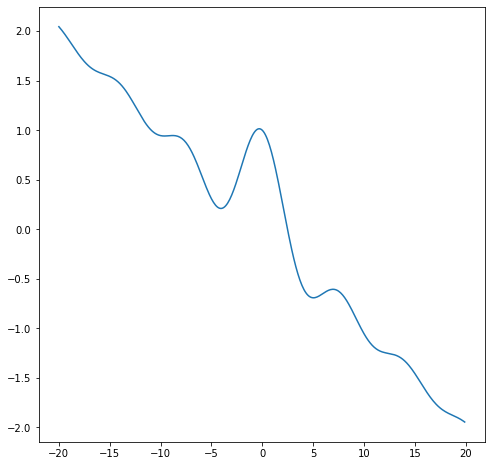

In [2]:
# Выглядит этот график как-то так:
def f(x):
    return (math.sin(x)/x - x/10)
plt.figure(figsize=(8, 8))
plt.plot(np.arange(-20, 20, 0.1), [f(x) for x in np.arange(-20, 20, 0.1)])

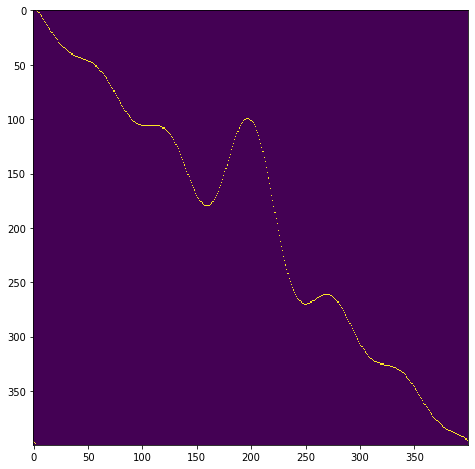

In [3]:
# Тут возникают вопросы... решать задачу picture-wise (то-есть учить генерировать из шума картинку с графиком) 
# или тренировать сеть предсказывать координаты точек? (из пачки рэндомных значений генерировать пачку пар (х, у))
# Если картинкой - тренировать нашу сеть на какой-то один выбранный масштаб? (по факту на один единственный пример)
# Или сделать разномасштабные реальные данные? Для начала пробуем научить на одну картинку.. 
# потом займемся вариантом с генерацией координат точек
target = np.zeros((400, 400))
for i, x in zip(range(target.shape[0]), np.arange(-20, 20, 0.1)):
    target[400-int((f(x)+2)*100), i] = 1

plt.figure(figsize=(8, 8))
plt.imshow(target)

C:\Users\Asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


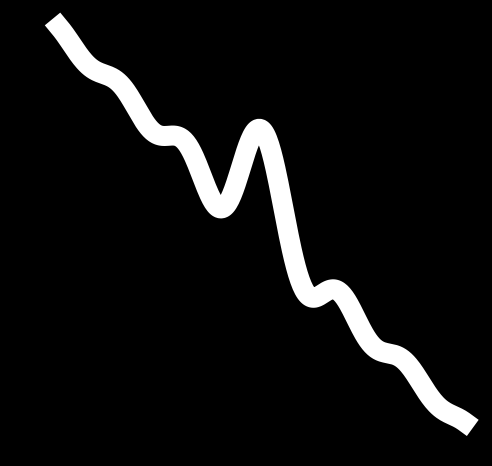

In [4]:
# Ну.. такое.. Лучше наверное из матплотлиба
fig = plt.figure(figsize=(8, 8), facecolor='black', edgecolor='none')
fig.add_subplot(111)
plt.plot(np.arange(-20, 20, 0.1), [f(x) for x in np.arange(-20, 20, 0.1)], c='white', linewidth=20)
ax = plt.gca()
ax.set_facecolor('black')
fig.canvas.draw()
data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

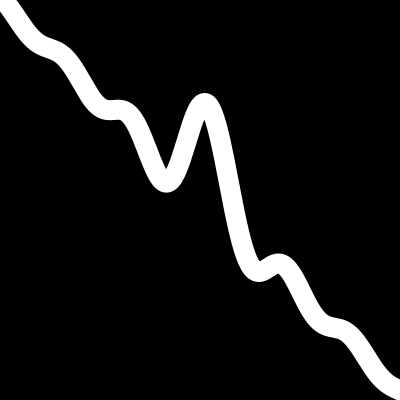

In [5]:
image = Image.fromarray(data)
image = image.crop((image.size[0]//2 - 400//2, \
                     image.size[1]//2 - 400//2, \
                     image.size[0]//2 + 400//2, \
                     image.size[1]//2 + 400//2))
image

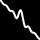

In [6]:
#image = Image.fromarray(data)
image = image.resize((40, 40), Image.ANTIALIAS)
image

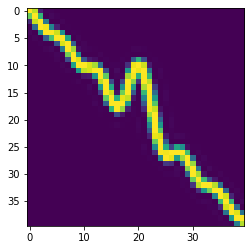

In [7]:
target = np.array(image)
target = target[:, :, 0]
target = target/255
plt.imshow(target)

In [8]:
target

array([[1.        , 0.90196078, 0.09019608, ..., 0.        , 0.        ,
        0.        ],
       [0.76862745, 1.        , 0.6627451 , ..., 0.        , 0.        ,
        0.        ],
       [0.11764706, 0.91764706, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.95294118,
        0.38039216],
       [0.        , 0.        , 0.        , ..., 0.55294118, 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.42745098,
        0.88627451]])

In [63]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activations = {
                'lrelu': nn.LeakyReLU(0.2, inplace=True),
                'relu': nn.ReLU(0.2)}
        
        def block(in_feat, out_feat, normalize=False, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]
                                                    
            if normalize:
                layers.append(nn.InstanceNorm1d(out_feat, 0.8))
                # layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation])
                                                      
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), 
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


In [23]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

In [243]:
latent_dim = 128
img_shape=(40, 40)

batch_size = 1 # (поскольку тренируем мы на одну картинку)

generator = Generator()
discriminator = Discriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.00005)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

adversarial_loss = torch.nn.BCELoss()

In [244]:
d_loss_history = []
g_loss_history = []

In [245]:
for epoch in range(1200):

    valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
    fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
    
    real_img = torch.FloatTensor([[target]])
    
    optimizer_G.zero_grad()
    
    #генерация шума
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))

    # Генерируем даные Генератором на основе шума
    gen_img = generator(z)

    # Подаем сгенерированые данные на Дискриминатор 
    validity = discriminator(gen_img)

    # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
    g_loss = adversarial_loss(validity, valid)

    # Делаем шаг обучения нашего Генератора
    g_loss.backward()
    optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

    optimizer_D.zero_grad()

    # Получаем предсказания дискриминатора на основе реальных данных
    real_pred = discriminator(real_img)

    # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
    d_real_loss = adversarial_loss(real_pred, valid)

    # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
    fake_pred = discriminator(gen_img.detach())

    # расчитываем ошибку предсказанного с фейковыми лейблами
    d_fake_loss = adversarial_loss(fake_pred, fake)

    # И усредняем два лосса в один
    d_loss = (d_real_loss + d_fake_loss) / 2

    d_loss.backward()
    optimizer_D.step()
    
    d_loss_history.append(d_loss.detach())
    g_loss_history.append(g_loss.detach())
    print(f'{d_loss.detach()} - {g_loss.detach()}')

0.6896471977233887 - 0.6702248454093933
0.683681845664978 - 0.6691957116127014
0.6768345236778259 - 0.6700968146324158
0.6708089709281921 - 0.6698880195617676
0.664004385471344 - 0.6714466214179993
0.6580049991607666 - 0.6716386675834656
0.6516004800796509 - 0.6727243065834045
0.6461283564567566 - 0.6723536252975464
0.6404918432235718 - 0.6725336909294128
0.6349525451660156 - 0.6724613904953003
0.6292212605476379 - 0.6727672815322876
0.6235713958740234 - 0.6730549931526184
0.6179624795913696 - 0.6732074618339539
0.6120051145553589 - 0.6739466190338135
0.6066142320632935 - 0.6737591028213501
0.6003440022468567 - 0.6754136085510254
0.5946487188339233 - 0.6758455038070679
0.5899667143821716 - 0.6743885278701782
0.5837286710739136 - 0.6759120225906372
0.5789360404014587 - 0.6746037006378174
0.5723717212677002 - 0.6766744256019592
0.5694682598114014 - 0.6716106534004211
0.5644029974937439 - 0.670802116394043
0.5566256642341614 - 0.6752055287361145
0.5502250790596008 - 0.6769701838493347
0.5

0.5379967093467712 - 0.648398220539093
0.5400290489196777 - 0.6443214416503906
0.5037370920181274 - 0.7148910164833069
0.4652164578437805 - 0.8020884394645691
0.48298096656799316 - 0.7590850591659546
0.44482678174972534 - 0.8511688113212585
0.44370946288108826 - 0.8500321507453918
0.411861777305603 - 0.9351101517677307
0.3816518485546112 - 1.0259685516357422
0.3991526663303375 - 0.9554765820503235
0.3799808919429779 - 1.0075256824493408
0.35575854778289795 - 1.082096815109253
0.35339033603668213 - 1.074453592300415
0.3225235044956207 - 1.1841983795166016
0.3290616273880005 - 1.1346700191497803
0.31088995933532715 - 1.1937062740325928
0.3271287679672241 - 1.1033974885940552
0.30100199580192566 - 1.1965805292129517
0.309063196182251 - 1.1420202255249023
0.3030182123184204 - 1.151003122329712
0.29864612221717834 - 1.1535859107971191
0.29764845967292786 - 1.1426594257354736
0.3059428334236145 - 1.0955162048339844
0.2587943375110626 - 1.2991044521331787
0.28655174374580383 - 1.1527993679046

0.5752939581871033 - 0.5280757546424866
0.5783494710922241 - 0.5291833281517029
0.5370767116546631 - 0.5949706435203552
0.5647398829460144 - 0.5524703860282898
0.5637960433959961 - 0.5532060265541077
0.560771644115448 - 0.5541622042655945
0.5629850625991821 - 0.5474826693534851
0.5956578254699707 - 0.5003997683525085
0.5680063962936401 - 0.5384442806243896
0.5589985251426697 - 0.5537789463996887
0.5852658748626709 - 0.5201799273490906
0.5822187662124634 - 0.5282983779907227
0.5708649158477783 - 0.5488368272781372
0.5501906871795654 - 0.5845494866371155
0.5679767727851868 - 0.5610783696174622
0.5600159168243408 - 0.5786257386207581
0.5708804130554199 - 0.5679962635040283
0.5486370921134949 - 0.6081194281578064
0.5873251557350159 - 0.5472233295440674
0.5730926990509033 - 0.5680626034736633
0.6102654337882996 - 0.5148679614067078
0.5866494178771973 - 0.5514349341392517
0.617597222328186 - 0.509442150592804
0.6324927806854248 - 0.4926210641860962
0.6131917834281921 - 0.5201020240783691
0.6

0.19267743825912476 - 1.5754425525665283
0.1767173707485199 - 1.7089035511016846
0.18957898020744324 - 1.5960183143615723
0.1974492222070694 - 1.5313286781311035
0.19472360610961914 - 1.5468584299087524
0.18625596165657043 - 1.6067571640014648
0.22548922896385193 - 1.3395870923995972
0.23053941130638123 - 1.3098515272140503
0.19702816009521484 - 1.5152157545089722
0.20806853473186493 - 1.4383690357208252
0.20094193518161774 - 1.4834672212600708
0.19136478006839752 - 1.5487459897994995
0.23084408044815063 - 1.298993706703186
0.22286073863506317 - 1.3407031297683716
0.21573127806186676 - 1.3803988695144653
0.23193079233169556 - 1.2903050184249878
0.23758956789970398 - 1.2627365589141846
0.23424112796783447 - 1.28659987449646
0.2637327015399933 - 1.1547856330871582
0.2702445387840271 - 1.1365302801132202
0.2537110447883606 - 1.2210774421691895
0.2549000084400177 - 1.2301020622253418
0.2574922442436218 - 1.232726812362671
0.297741562128067 - 1.0708380937576294
0.28688549995422363 - 1.12655

0.3409719467163086 - 1.1546064615249634
0.3130168914794922 - 1.3369941711425781
0.31109511852264404 - 1.3649734258651733
0.3017505407333374 - 1.409365177154541
0.3383180499076843 - 1.1813081502914429
0.2993382215499878 - 1.350036382675171
0.2946181297302246 - 1.3349045515060425
0.288374125957489 - 1.3323447704315186
0.3375881314277649 - 1.084230661392212
0.3161081075668335 - 1.1777715682983398
0.3303089737892151 - 1.130574345588684
0.3193812668323517 - 1.208185076713562
0.30788010358810425 - 1.30820894241333
0.31344178318977356 - 1.323487639427185
0.3711598515510559 - 1.0799508094787598
0.34365367889404297 - 1.2373088598251343
0.3439582586288452 - 1.2651481628417969
0.3260122537612915 - 1.372237205505371
0.3259836435317993 - 1.345734715461731
0.2906310558319092 - 1.5218225717544556
0.3219227194786072 - 1.264273762702942
0.3284784257411957 - 1.1765553951263428
0.310974657535553 - 1.2178969383239746
0.2863701581954956 - 1.3129067420959473
0.27619850635528564 - 1.339232325553894
0.2631992

0.4947868585586548 - 0.8532992601394653
0.4069817066192627 - 1.1765278577804565
0.4397251009941101 - 1.0110529661178589
0.44303107261657715 - 0.9527465105056763
0.4505225121974945 - 0.8913405537605286
0.4268799424171448 - 0.9351452589035034
0.4624103009700775 - 0.8333510756492615
0.4480118155479431 - 0.8998186588287354
0.45145004987716675 - 0.9240679144859314
0.439269483089447 - 0.998921811580658
0.4636766016483307 - 0.9434887170791626
0.4398370385169983 - 1.0318489074707031
0.40036821365356445 - 1.1730966567993164
0.3275012969970703 - 1.5081127882003784
0.4078196585178375 - 0.9967014789581299
0.36257484555244446 - 1.0896117687225342
0.41717690229415894 - 0.8695650696754456
0.3724333941936493 - 0.9999089241027832
0.40909162163734436 - 0.8939976096153259
0.262306809425354 - 1.6447685956954956
0.3727385997772217 - 1.0461349487304688
0.34552001953125 - 1.1675001382827759
0.36199676990509033 - 1.1087971925735474
0.3406525254249573 - 1.210569977760315
0.3945865035057068 - 1.0024206638336182

In [54]:
optimizer_D.step()

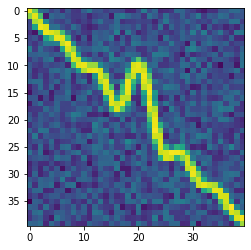

In [246]:
plt.imshow(gen_img.detach()[0])

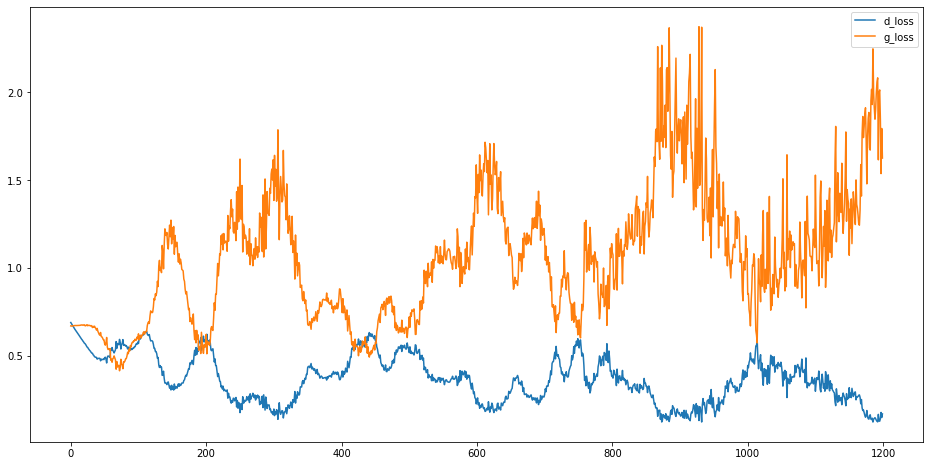

In [247]:
plt.figure(figsize=(16, 8))
plt.plot(range(len(d_loss_history)), d_loss_history)
plt.plot(range(len(g_loss_history)), g_loss_history)
plt.legend(('d_loss', 'g_loss'))

### Ну - это явно легко и быстро. На единственный таргет натренироваться..

In [738]:
# Теперь с парами точек
pts_dataset = np.zeros((np.arange(-20, 20, 0.0005).shape[0], 2))

In [739]:
for i, x in enumerate(np.arange(-20, 20, 0.0005)):
    pts_dataset[i] = (x, f(x))

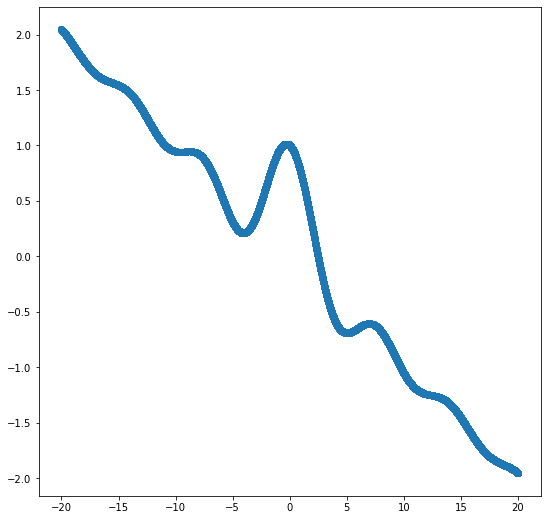

In [740]:
plt.figure(figsize=(9, 9))
plt.scatter(pts_dataset[:, 0], pts_dataset[:, 1])

In [741]:
pts_dataset.shape

(80000, 2)

In [742]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activations = {
                'lrelu': nn.LeakyReLU(0.2, inplace=True),
                'relu': nn.ReLU(0.2),
                'tanh': nn.Tanh()}
        
        def block(in_feat, out_feat, normalize=False, activation='tanh'):
            layers = [nn.Linear(in_feat, out_feat)]
                                                    
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            if activation:
                layers.append(self.activations[activation])
                                                      
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), 
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


In [751]:
latent_dim = 8
img_shape=(2, )

batch_size = 128

generator = Generator()
discriminator = Discriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.00005)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

adversarial_loss = torch.nn.BCELoss()

In [744]:
class Function_Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        item = self.data[idx,:]
        label = 1.0
        if self.transform != None:
            item = transform(item)
            
        return (item, label) 

In [752]:
dataset = Function_Dataset(pts_dataset)
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [753]:
torch.set_num_threads(16)

In [754]:
d_loss_history = []
g_loss_history = []

In [755]:
for epoch in range(100):
    
    for pts, _ in train_loader:

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        real_pt =  Variable(pts.type(torch.FloatTensor))

        optimizer_G.zero_grad()

        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(-1, 1, (batch_size, latent_dim))))

        # Генерируем даные Генератором на основе шума
        gen_pt = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_pt)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)

        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

    ######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_pt)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)

        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_pt.detach())

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        d_loss_history.append(d_loss.detach())
        g_loss_history.append(g_loss.detach())
    print(f'epoch: {epoch}, d_loss: {d_loss.detach()}, g_loss: {g_loss.detach()}')

epoch: 0, d_loss: 0.40832456946372986, g_loss: 0.9787133932113647
epoch: 1, d_loss: 0.1443164348602295, g_loss: 2.439727544784546
epoch: 2, d_loss: 0.14208856225013733, g_loss: 2.521454095840454
epoch: 3, d_loss: 0.12860044836997986, g_loss: 2.6179723739624023
epoch: 4, d_loss: 0.13208194077014923, g_loss: 2.754493236541748
epoch: 5, d_loss: 0.0841267853975296, g_loss: 2.7250492572784424
epoch: 6, d_loss: 0.053193800151348114, g_loss: 3.607016086578369
epoch: 7, d_loss: 0.03434063494205475, g_loss: 3.882582902908325
epoch: 8, d_loss: 0.060577392578125, g_loss: 3.316333055496216
epoch: 9, d_loss: 0.09882514178752899, g_loss: 2.7222483158111572
epoch: 10, d_loss: 0.15420694649219513, g_loss: 3.130431890487671
epoch: 11, d_loss: 0.07729919999837875, g_loss: 3.0955467224121094
epoch: 12, d_loss: 0.05723973736166954, g_loss: 4.023534774780273
epoch: 13, d_loss: 0.09998820722103119, g_loss: 3.2121973037719727
epoch: 14, d_loss: 0.01711583510041237, g_loss: 4.187757968902588
epoch: 15, d_loss

In [784]:
# Теперь попробуем применить сеть для генерации

In [756]:
set_of_points = []
for i in range(20000):
    z = Variable(torch.FloatTensor(np.random.normal(-1, 1, (1, latent_dim))))
    gen_pt = generator(z)
    set_of_points.append(gen_pt.detach().numpy()[0])

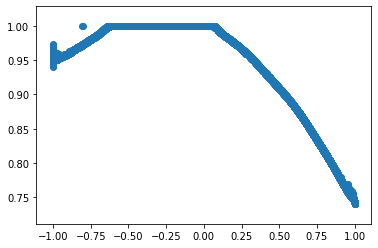

In [750]:
plt.scatter(np.array(set_of_points)[:, 0], np.array(set_of_points)[:, 1])

Диапазон (-1, 1) 
Посмотрим как выглядит исходная функция в этом диапазоне

In [759]:
pts_dataset = np.zeros((np.arange(-1, 1, 0.0005).shape[0], 2))

In [760]:
for i, x in enumerate(np.arange(-1, 1, 0.0005)):
    pts_dataset[i] = (x, f(x))

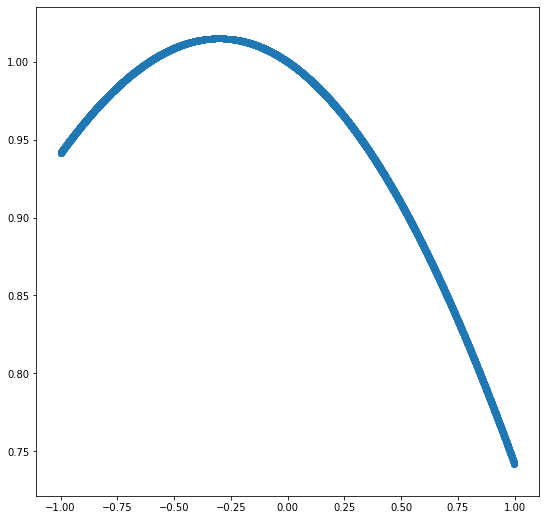

In [761]:
plt.figure(figsize=(9, 9))
plt.scatter(pts_dataset[:, 0], pts_dataset[:, 1])

Видимо оно работает.. Но диапазон выходных значений обрезан (-1, 1).. Tanh функция (которая у нас там в последнем слое используется) имеет такой выходной диапазон.. Похоже надо делать чисто линейный выходной слой.

In [767]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.activations = {
                'lrelu': nn.LeakyReLU(0.2, inplace=True),
                'relu': nn.ReLU(0.2),
                'tanh': nn.Tanh()}
        
        def block(in_feat, out_feat, normalize=False, activation='tanh'):
            layers = [nn.Linear(in_feat, out_feat)]
                                                    
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            if activation:
                layers.append(self.activations[activation])
                                                      
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False), 
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape)))
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img

In [775]:
pts_dataset = np.zeros((np.arange(-20, 20, 0.01).shape[0], 2))
for i, x in enumerate(np.arange(-20, 20, 0.01)):
    pts_dataset[i] = (x, f(x))
pts_dataset.shape

(4000, 2)

In [779]:
dataset = Function_Dataset(pts_dataset)
train_loader = DataLoader(dataset, batch_size = batch_size, shuffle=True)

In [780]:
latent_dim = 8
img_shape=(2, )

batch_size = 32

generator = Generator()
discriminator = Discriminator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

adversarial_loss = torch.nn.BCELoss()

In [781]:
d_loss_history = []
g_loss_history = []

In [782]:
for epoch in range(100):
    
    for pts, _ in train_loader:

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        real_pt =  Variable(pts.type(torch.FloatTensor))

        optimizer_G.zero_grad()

        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(-1, 1, (batch_size, latent_dim))))

        # Генерируем даные Генератором на основе шума
        gen_pt = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_pt)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)

        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

    ######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_pt)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)

        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_pt.detach())

        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)

        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        d_loss_history.append(d_loss.detach())
        g_loss_history.append(g_loss.detach())
    print(f'epoch: {epoch}, d_loss: {d_loss.detach()}, g_loss: {g_loss.detach()}')

epoch: 0, d_loss: 1.4340866804122925, g_loss: 0.6816531419754028
epoch: 1, d_loss: 0.35472577810287476, g_loss: 1.7718770503997803
epoch: 2, d_loss: 0.535932719707489, g_loss: 0.6208657026290894
epoch: 3, d_loss: 0.7147611975669861, g_loss: 0.8416822552680969
epoch: 4, d_loss: 0.7278529405593872, g_loss: 0.7829317450523376
epoch: 5, d_loss: 0.6946714520454407, g_loss: 0.7850910425186157
epoch: 6, d_loss: 0.6999168395996094, g_loss: 0.6586548089981079
epoch: 7, d_loss: 0.6829491853713989, g_loss: 0.7065653800964355
epoch: 8, d_loss: 0.686278223991394, g_loss: 0.6826590895652771
epoch: 9, d_loss: 0.6827139854431152, g_loss: 0.7286648750305176
epoch: 10, d_loss: 0.6901321411132812, g_loss: 0.8023828268051147
epoch: 11, d_loss: 0.6812489032745361, g_loss: 0.7130099534988403
epoch: 12, d_loss: 0.7016451954841614, g_loss: 0.6661342978477478
epoch: 13, d_loss: 0.6871283054351807, g_loss: 0.6851788759231567
epoch: 14, d_loss: 0.6923244595527649, g_loss: 0.6634992361068726
epoch: 15, d_loss: 0.

In [788]:
set_of_points = []
for i in range(2000):
    z = Variable(torch.FloatTensor(np.random.normal(-1, 1, (1, latent_dim))))
    gen_pt = generator(z)
    set_of_points.append(gen_pt.detach().numpy()[0])

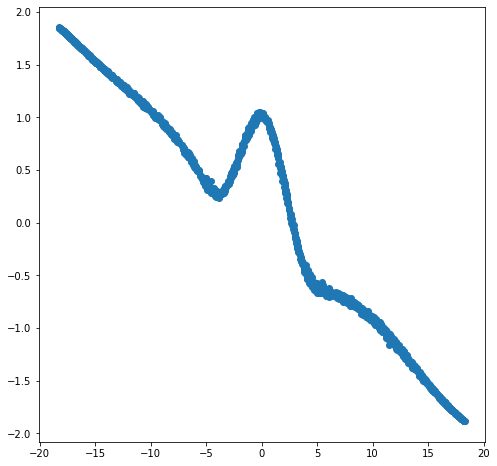

In [789]:
plt.figure(figsize=(8, 8))
plt.scatter(np.array(set_of_points)[:, 0], np.array(set_of_points)[:, 1])

### Вобщем, как-то так...
Странно конечно выглядят цифры лоссов... Вообще ни о чем не говорят. Но сеть обучилась тем не менее..

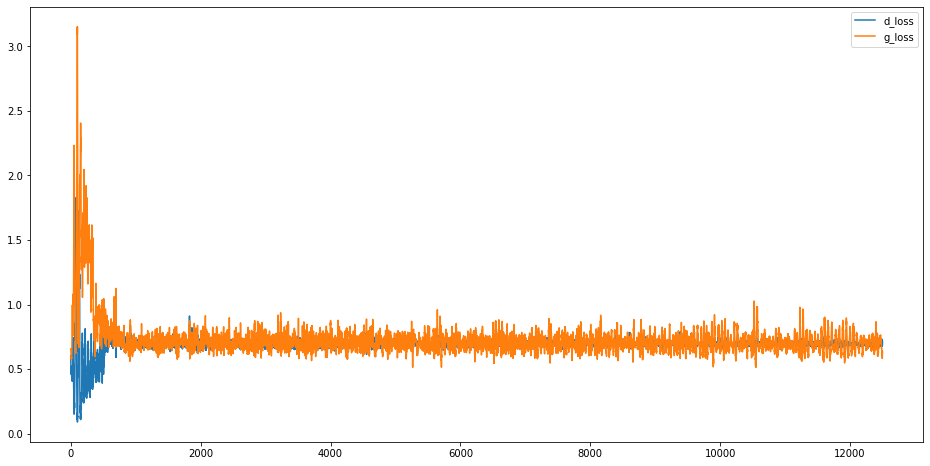

In [785]:
plt.figure(figsize=(16, 8))
plt.plot(range(len(d_loss_history)), d_loss_history)
plt.plot(range(len(g_loss_history)), g_loss_history)
plt.legend(('d_loss', 'g_loss'))